# Project CDA - Web data: Amazon movie reviews

We started by creating the subset using the dataset available (https://snap.stanford.edu/data/web-Movies.html). We converted the .txt file in a .parquet file to have a better performance treating the data making the analysis faster.

In [1]:
# Dependecies

import pandas as pd
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [ ]:
product_id = []
user_id = []
rev_helpful = [] # the helpfulness field will be a tuple where the first value is the number of users who found the review helpful and the last value represents the total number of users who read the review
rev_score = []
rev_time = []

with open("movies.txt", encoding="utf-8", errors="ignore") as file:
    
    block = []
    for line in file:
        if line.strip() == "":
            if block:
                for item in block:
                    if item.startswith("product/productId:"):
                        product_id.append(item.split(": ")[1].strip())
                    elif item.startswith("review/userId:"):
                        user_id.append(item.split(": ")[1].strip())
                    elif item.startswith("review/helpfulness:"):
                        help_val = item.split(": ")[1].strip()
                        good, total = map(int, help_val.split("/"))  # Parse as ints
                        rev_helpful.append((good, total)) # store helpfulness score as a tuple
                    elif item.startswith("review/score:"):
                        rev_score.append(float(item.split(": ")[1].strip()))
                    elif item.startswith("review/time:"):
                        rev_time.append(int(item.split(": ")[1].strip()))
                block = []
        else:
            block.append(line.strip())

    # Process the last block if the file does not end with a blank line
    if block:
        for item in block:
            if item.startswith("product/productId:"):
                product_id.append(item.split(": ")[1].strip())
            elif item.startswith("review/userId:"):
                user_id.append(item.split(": ")[1].strip())
            elif item.startswith("review/helpfulness:"):
                help_val = item.split(": ")[1].strip()
                good, total = map(int, help_val.split("/"))  # Parse as ints
                rev_helpful.append((good, total)) # store helpfulness score as a tuple
            elif item.startswith("review/score:"):
                rev_score.append(float(item.split(": ")[1].strip()))
            elif item.startswith("review/time:"):
                rev_time.append(int(item.split(": ")[1].strip()))
    
# make dataframe
df = pd.DataFrame(
    {
        "prod_id": product_id,
        "user_id": user_id,
        "rev_help": rev_helpful,
        "rev_score": rev_score,
        "rev_time": rev_time,
    }
)

# Add a new column for the sum of helpfulness good and total values
df["helpfulness_sum"] = df["rev_help"].apply(lambda x: x[0] + x[1])

# Filter DataFrame to retain rows with the maximum helpfulness sum for each unique review
df_max_help = df.loc[
    df.groupby(["prod_id", "user_id", "rev_score", "rev_time"])["helpfulness_sum"].idxmax()
]

# Drop sum column
df_max_help = df_max_help.drop(columns=["helpfulness_sum"])

# make parquet file
df_max_help.to_parquet("movies_max_help.parquet", index=False)

In [2]:
movies_pq = pd.read_parquet("movies_max_help.parquet")

In [3]:
#print do n de rows (esperado 7911684)
print("Number of rows: ", movies_pq.shape[0])

Number of rows:  7882689


In [4]:
movies_pq.head()

,prod_id,user_id,rev_help,rev_score,rev_time
0,0001489305,A3KF4IP2MUS8QQ,"[0, 0]",4.0,1246233600
1,0001501348,A1GR2UCKC2NPOT,"[0, 0]",5.0,1289692800
2,0001501348,A3CFBMPKT79R89,"[0, 0]",5.0,1252627200
3,0001516035,A2X0GJ1KR9B8U0,"[0, 0]",5.0,1335830400
4,0001517791,A2GWNIH0RTOM67,"[0, 0]",5.0,1294790400


In [5]:
movies_pq.dtypes

prod_id       object
user_id       object
rev_help      object
rev_score    float64
rev_time       int64
dtype: object

In [6]:

movies_pq['rev_time'] = pd.to_datetime(movies_pq['rev_time'], unit='s')

print(movies_pq.head())


      prod_id         user_id rev_help  rev_score   rev_time
0  0001489305  A3KF4IP2MUS8QQ   [0, 0]        4.0 2009-06-29
1  0001501348  A1GR2UCKC2NPOT   [0, 0]        5.0 2010-11-14
2  0001501348  A3CFBMPKT79R89   [0, 0]        5.0 2009-09-11
3  0001516035  A2X0GJ1KR9B8U0   [0, 0]        5.0 2012-05-01
4  0001517791  A2GWNIH0RTOM67   [0, 0]        5.0 2011-01-12


In [7]:
# Split the helpfulness column into two separate columns
movies_pq[['helpful_votes', 'total_votes']] = pd.DataFrame(movies_pq['rev_help'].tolist(), index=movies_pq.index)

# Calculate the helpfulness ratio (if total_votes > 0)
movies_pq['helpfulness_ratio'] = movies_pq['helpful_votes'] / movies_pq['total_votes']
movies_pq['helpfulness_ratio'].fillna(0, inplace=True)  # Replace NaN with 0 for cases where total_votes is 0

# Display the first few rows
print(movies_pq.head())

      prod_id         user_id rev_help  rev_score   rev_time  helpful_votes  \
0  0001489305  A3KF4IP2MUS8QQ   [0, 0]        4.0 2009-06-29              0   
1  0001501348  A1GR2UCKC2NPOT   [0, 0]        5.0 2010-11-14              0   
2  0001501348  A3CFBMPKT79R89   [0, 0]        5.0 2009-09-11              0   
3  0001516035  A2X0GJ1KR9B8U0   [0, 0]        5.0 2012-05-01              0   
4  0001517791  A2GWNIH0RTOM67   [0, 0]        5.0 2011-01-12              0   

   total_votes  helpfulness_ratio  
0            0                0.0  
1            0                0.0  
2            0                0.0  
3            0                0.0  
4            0                0.0  


/var/folders/qj/ms5g84zs0x15wxhbc3kjq8940000gp/T/ipykernel_51395/280402821.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_pq['helpfulness_ratio'].fillna(0, inplace=True)  # Replace NaN with 0 for cases where total_votes is 0


In [8]:
print(movies_pq['rev_score'].describe())


count    7.882689e+06
mean     4.099471e+00
std      1.261131e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rev_score, dtype: float64


In [9]:
#reviews with scores less than 3
low_score_reviews = movies_pq[movies_pq['rev_score'] < 3]
print(low_score_reviews)


            prod_id         user_id   rev_help  rev_score   rev_time  \
92       0005019486  A1K0R6W6CPL5RG     [0, 5]        1.0 2007-03-08   
93       0005019486  A1O2RTYPGZLMJY     [0, 0]        1.0 2012-09-02   
102      000504846X  A18XPG61ZLIBM7   [63, 95]        1.0 2008-03-14   
104      000504846X  A1JH02MQ0LC27C  [44, 101]        1.0 2007-01-01   
107      000504846X  A1OF8C6PDH28BG   [24, 36]        1.0 2011-10-17   
...             ...             ...        ...        ...        ...   
7882604  B009VNEPAI   AADM5VTLZOTXT     [3, 4]        2.0 2010-04-17   
7882612  B009VNEPAI   ARY408FHTY9LS    [5, 13]        2.0 2008-01-02   
7882615  B009VNEPAI   AV6QDP8Q0ONK4     [1, 1]        2.0 2010-06-04   
7882625  B009VOLSA2  A1GSR7RGCG1QYZ    [1, 40]        1.0 2006-01-22   
7882673  B009VOLSA2   AHFAUGKV8ICDW    [1, 19]        1.0 2007-02-23   

         helpful_votes  total_votes  helpfulness_ratio  
92                   0            5           0.000000  
93                   

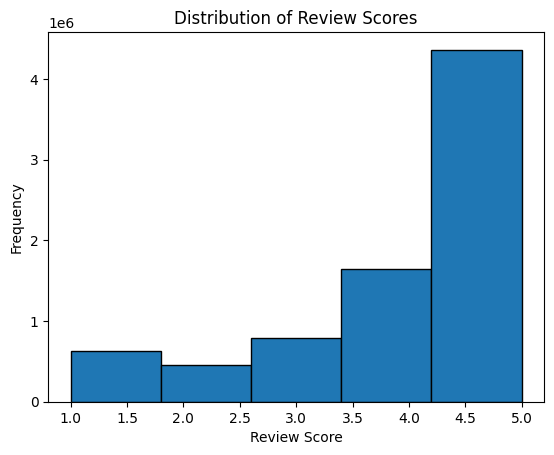

In [ ]:

#just a dummy score distribution
movies_pq['rev_score'].plot(kind='hist', bins=5, edgecolor='black')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()


In [11]:
movies_pq = movies_pq.drop_duplicates(subset=['user_id', 'prod_id'])


In [12]:
print(movies_pq.isna().sum())


prod_id              0
user_id              0
rev_help             0
rev_score            0
rev_time             0
helpful_votes        0
total_votes          0
helpfulness_ratio    0
dtype: int64


In [13]:
print("Building...")
G = nx.Graph()

# Add user and product nodes
G.add_nodes_from(movies_pq['user_id'].unique(), type='user')  # Add all unique users as nodes with attribute type='user'
G.add_nodes_from(movies_pq['prod_id'].unique(), type='product')  # Add all unique products as nodes with attribute type='product'

# Add edges with attributes
edges = movies_pq[['user_id', 'prod_id', 'rev_time']].to_records(index=False)  # Convert to tuple records
G.add_edges_from([(row.user_id, row.prod_id, {'time': row.rev_time}) for row in edges])  # Add edges with time

# Count total users and products
print("Counting...")
users = 0
products = 0
for _, attr in G.nodes(data=True):
    node_type = attr.get('type')
    if node_type == 'user':
        users += 1
    elif node_type == 'product':
        products += 1

print(f"Total number of users: {users}") # 889176 users (correct)
print(f"Total number of products: {products}") # 253059 products (correct)
print(f"Total number of edges (reviews): {G.number_of_edges()}") # 7831442 edges (reviews) (wrong: real value is 7911684)

Building...
Counting...
Total number of users: 889176
Total number of products: 253059
Total number of edges (reviews): 7831442


In [17]:
#how many unique user-product pairs in the dataset
unique_pairs_count = movies_pq[['user_id', 'prod_id']].drop_duplicates().shape[0]
print(f"Unique user-product pairs in dataset: {unique_pairs_count}")

#edges in the graph
graph_edges_count = G.number_of_edges()
print(f"Edges in the graph: {graph_edges_count}")


Unique user-product pairs in dataset: 7831442
Edges in the graph: 7831442


In [18]:
#find duplicate rows in the dataset :))))
duplicates = movies_pq.duplicated(subset=['user_id', 'prod_id'], keep=False)
duplicates_count = duplicates.sum()
print(f"Number of duplicate reviews (same user-product pairs): {duplicates_count}")


Number of duplicate reviews (same user-product pairs): 0


In [19]:
#rows with problems
problematic_rows = movies_pq[
    movies_pq['user_id'].str.contains(r'\s', na=False) | 
    movies_pq['prod_id'].str.contains(r'\s', na=False)
]
print(f"Number of problematic rows: {problematic_rows.shape[0]}")


Number of problematic rows: 0


I AM GETTING NERVOUS NOW

In [21]:
dataset_pairs = set(zip(movies_pq['user_id'], movies_pq['prod_id']))
graph_pairs = set(G.edges())
missing_pairs = dataset_pairs - graph_pairs
print(f"Missing user-product pairs in graph: {len(missing_pairs)}")


Missing user-product pairs in graph: 0


no really what the actual fuck is going on i am reviewing this later

## Network Analysis

Network structure

In [14]:
#Number nodes and edges
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

#Degree distribution
degrees = [deg for _, deg in G.degree()]
print(f"Average degree: {sum(degrees) / len(degrees):.2f}")


Nodes: 1142235
Edges: 7831442
Average degree: 13.71


Degree Centrality

In [15]:
#users and products
user_centrality = {n: d for n, d in G.degree if G.nodes[n]['type'] == 'user'}
product_centrality = {n: d for n, d in G.degree if G.nodes[n]['type'] == 'product'}


top_users = sorted(user_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_products = sorted(product_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 users by degree:", top_users)
print("Top 10 products by degree:", top_products)


Top 10 users by degree: [('A16CZRQL23NOIW', 10777), ('A3LZGLA88K0LA0', 10262), ('ANCOMAI0I7LVG', 9611), ('A2NJO6YE954DBH', 8636), ('ABO2ZI2Y5DQ9T', 7991), ('A39CX0EE4BZCZC', 7657), ('A35ZK3M8L9JUPX', 7590), ('A10ODC971MDHV8', 7440), ('A328S9RN3U5M68', 7185), ('A1X054KUYG5V', 6711)]
Top 10 products by degree: [('B002QZ1RS6', 956), ('B007FQDPL8', 952), ('B00005JPS8', 918), ('B001C08RHA', 918), ('B001FD5KJM', 918), ('B001GAPC1K', 918), ('B001I1NGHY', 918), ('B001KZG99A', 918), ('B001FZ9AAU', 917), ('B001HUHBE0', 917)]


Bipartite graph

In [16]:
from networkx.algorithms import bipartite

product_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'product']
product_graph = bipartite.weighted_projected_graph(G, product_nodes)

print(f"Product Product Graph: {nx.info(product_graph)}")

#top pairs of related products
top_product_pairs = sorted(product_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10] #weighted by shared users
print("Top related products:", top_product_pairs)


KeyboardInterrupt: 

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

#Communities in the product graph
communities = list(greedy_modularity_communities(product_graph))
print(f"Number of communities: {len(communities)}")

for i, community in enumerate(communities[:5]):
    print(f"Community {i+1}: {list(community)[:10]}")  #first 10 nodes in the community


In [ ]:
import datetime

for u, v, attr in G.edges(data=True):
    attr['time'] = datetime.datetime.fromtimestamp(attr['time']) #readable dates

#time range: 2009 to 2012
start_date = datetime.datetime(2009, 1, 1)
end_date = datetime.datetime(2012, 1, 1)

edges_in_range = [(u, v) for u, v, attr in G.edges(data=True) if start_date <= attr['time'] <= end_date]
print(f"Reviews between {start_date} and {end_date}: {len(edges_in_range)}")


In [ ]:

#dummy bipartite network
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, node_size=10, alpha=0.6, edge_color='gray')
plt.title("User-Product Bipartite Graph")
plt.show()


In [ ]:
#dummy subgraph 
sub_nodes = list(G.nodes)[:1000]  #subset of nodes
subgraph = G.subgraph(sub_nodes)

pos = nx.spring_layout(subgraph, seed=42)
plt.figure(figsize=(10, 10))
nx.draw(subgraph, pos, node_size=10, alpha=0.7, edge_color='blue')
plt.title("Subgraph Visualization")
plt.show()
